Main changes  
1. BCE loss
2. cnn batchsize =1, and pooling -> FFC

In [1]:
from google.colab import drive
drive.mount('/gdrive')

from pathlib import Path
drive_path = Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/')

Mounted at /gdrive


In [2]:
from exp.nb_08 import *

In [3]:
drive_data_path = drive_path/'data/v1'

In [4]:
(drive_data_path).ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/dev'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/ser.tar-v1.gz')]

In [5]:
class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'

    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)

    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)

    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)


In [14]:
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)

class Reshape():
    "transpose to [n_features, n_frames]"
    _order=12
    def __call__(self, item):
        w, h = item.shape
        return item.view(h, w)

class Enlengthen():
    "if n_features is smaller than threshold, concat them"
    _order = 14
    def __init__(self, thres):
        self.thres = thres
    def __call__(self, item):
        if item.shape[-1] > self.thres: return item
        return torch.cat([item, item], dim=-1)

class DummyChannel():
    "insert pseudo axis in height [n_features, 1, n_frames]"
    _order = 30
    def __call__(self, item):
        return item.unsqueeze(1)

def re_labeler(fn, pat, subcl='act'):
    assert subcl in ['act', 'val', 'all']
    if subcl=='all': return tuple(int(i) for i in re.findall(pat, str(fn)))
    else:
        return re.findall(pat, str(fn))[0] if pat == 'act' else re.findall(pat, str(fn))[1]


In [7]:
import random

In [8]:
def random_splitter(fn, p_valid): return random.random() < p_valid

In [9]:
# !pip install -qq ipdb

In [10]:
# from ipdb import set_trace

In [11]:
class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None

    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            # set_trace()
            self.vocab = uniqueify(items)
            # self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [torch.tensor(o).float() for o in items]
    def proc1(self, item):  return self.otoi[item]

    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]


In [12]:
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
        #    and '_0_0' in f
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [13]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs, **kwargs))

In [70]:
train_path = drive_data_path/'train'
tfms = [Reshape(), DummyChannel(), Enlengthen(100)]
al=AudioList.from_files(train_path, tfms=tfms)

In [71]:
al[4].shape, al.items.__len__()

(torch.Size([26, 1, 136]), 7800)

In [72]:
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

In [73]:
label_pat = r'_(\d+)'
emotion_labeler = partial(re_labeler, pat=label_pat, subcl='all')
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.01))
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [74]:
ll.y

ItemList (7723 items)
[tensor([1., 1.]), tensor([0., 0.]), tensor([0., 0.]), tensor([1., 0.]), tensor([1., 1.]), tensor([1., 0.]), tensor([1., 1.]), tensor([1., 0.]), tensor([1., 0.]), tensor([1., 1.])...]
Path: /gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train

In [75]:
bs=1

In [76]:
c_in = ll.train[0][0].shape[0]
c_out = 2
data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

In [77]:
data.train_dl.batch_size, data.valid_dl.batch_size

(1, 1)

In [23]:
data.c_in, data.c_out

(26, 2)

In [24]:
xb, yb = next(iter(data.train_dl))

In [25]:
xb.shape

torch.Size([1, 26, 1, 129])

In [26]:
yb

tensor([[1., 1.]])

## Model

In [27]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)

    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}

    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                #Create a state for p and call all the statistics to initialize it.
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)
    
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-1, )    

In [28]:
def get_defaults(d): return getattr(d,'_defaults',{})

In [164]:
AvgStats

exp.nb_04.AvgStats

In [166]:
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)

    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0

    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1

    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')

        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order):
            res = cb(cb_name) and res
        return res

class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train

    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += torch.tensor(m(run.pred, run.yb)) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        print(self.run.n_iter / self.run.iters, stats)
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

# https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
from timeit import default_timer as timer
class Recorder(Callback):
    def __init__(self):
        self.tot_time = []

    def begin_fit(self):self.lrs,self.losses = [],[]
    
    def begin_epoch(self):
        self.start_time = timer()

    def after_epoch(self):
        self.tot_time.append(timer() - self.start_time)

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self):
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)

class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9

    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr

    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [191]:
class FramesizeFilter(Callback):
    "if the size of n_frames is less than 100, raise CancelBatchException"
    def begin_batch(self):
        if self.run.xb.shape[-1] < 100:
            raise CancelBatchException()

class SaveModelParam(Callback):
    def __init__(self, m_path, f_name:str):
        self.m_path = Path(m_path)
        self.f_name = f_name
    def after_epoch(self):
        self.m_path.mkdir(parents=True, exist_ok=True)
        checkpoint_dict = {
            'model': self.run.model.state_dict(),
        }
        f_path = self.m_path/f"{self.f_name}_{self.run.epoch}.pt"
        torch.save(checkpoint_dict, f_path)
        print(f'model parameters succesfully saved to {f_path}!')


In [168]:
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x):
        return x.squeeze(-1).permute(1,0)

In [169]:
class StatMean(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sigmoid()
    def forward(self, x):
        return self.f(x.mean(0, keepdim=True))

In [170]:
model = nn.Sequential(
    nn.Conv1d(1,8, kernel_size=30, stride=1),GeneralRelu(),
    nn.Conv1d(8,16, kernel_size=25),GeneralRelu(),
    nn.Conv1d(16,32, kernel_size=18),GeneralRelu(),
    nn.Conv1d(32,64, kernel_size=7),GeneralRelu(),
    nn.Conv1d(64,128, kernel_size=5),GeneralRelu(),
    nn.Conv1d(128,128, kernel_size=3),GeneralRelu(), #26, 128, 18 - based on 100 frames
    nn.AdaptiveAvgPool1d(1), #26, 128, 1
    Flatten(),
    nn.Linear(26, 2),
    StatMean()
    )

In [171]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([4.6458, 5.4130, 6.5964, 6.8884, 6.8241, 7.1415, 7.2152, 7.1492, 6.6828,
        6.7434, 6.8610, 6.9456, 7.2149, 7.3144, 7.3993, 7.1714, 7.3913, 7.5860,
        7.3430, 7.3854, 7.4977, 7.4650, 7.3808, 7.0497, 6.7768, 6.4319])
_s = tensor([1.6839, 2.3302, 2.6372, 2.6552, 2.7861, 2.7495, 2.7446, 2.6085, 2.5018,
        2.3586, 2.3367, 2.3888, 2.4452, 2.4944, 2.4172, 2.4300, 2.3737, 2.4037,
        2.4891, 2.4774, 2.4399, 2.3689, 2.2110, 2.2310, 2.2802, 2.2686])
norm_ser = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self):
        self.run.xb = self.tfm(self.xb).squeeze(0)
        # self.run.yb = self.yb.squeeze(0)

In [192]:
cbfs = [partial(AvgStatsCallback,accuracy),
        partial(SaveModelParam,drive_path/'checkpoints','ser-cnn-ffc-loss-bce'),
        Recorder,
        FramesizeFilter,
        CudaCallback]

In [193]:
cbfs.append(partial(BatchTransformXCallback, norm_ser))

In [194]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [195]:
def get_learn_run(model, data, lr, cbs=None, opt_func=None, **kwargs):
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [196]:
learn,run = get_learn_run(model, data, 0.2, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)], opt_func=opt_func, loss_func = nn.BCELoss()
)

In [197]:
def model_summary(run, learn, data, find_all=False):
    xb,yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device#Model may not be on the GPU yet
    xb,yb = xb.to(device),yb.to(device)
    mods = learn.model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: learn.model(xb)

In [198]:
model_summary(run, learn, data)

Conv1d(1, 8, kernel_size=(30,), stride=(1,))
torch.Size([26, 8, 282])

GeneralRelu()
torch.Size([26, 8, 282])

Conv1d(8, 16, kernel_size=(25,), stride=(1,))
torch.Size([26, 16, 258])

GeneralRelu()
torch.Size([26, 16, 258])

Conv1d(16, 32, kernel_size=(18,), stride=(1,))
torch.Size([26, 32, 241])

GeneralRelu()
torch.Size([26, 32, 241])

Conv1d(32, 64, kernel_size=(7,), stride=(1,))
torch.Size([26, 64, 235])

GeneralRelu()
torch.Size([26, 64, 235])

Conv1d(64, 128, kernel_size=(5,), stride=(1,))
torch.Size([26, 128, 231])

GeneralRelu()
torch.Size([26, 128, 231])

Conv1d(128, 128, kernel_size=(3,), stride=(1,))
torch.Size([26, 128, 229])

GeneralRelu()
torch.Size([26, 128, 229])

AdaptiveAvgPool1d(output_size=1)
torch.Size([26, 128, 1])

Flatten()
torch.Size([128, 26])

Linear(in_features=26, out_features=2, bias=True)
torch.Size([128, 2])

StatMean(
  (f): Sigmoid()
)
torch.Size([1, 2])



In [199]:
run.fit(10, learn)

0.0 
0.00012948336138806163 train: [1.4664919926570013, tensor(0., device='cuda:0')]
0.00025896672277612325 train: [1.461257054255559, tensor(0., device='cuda:0')]
0.0003884500841641849 train: [1.1334270575107672, tensor(0.1667, device='cuda:0')]
0.0005179334455522465 train: [0.9700820629413311, tensor(0.2500, device='cuda:0')]
0.0006474168069403081 train: [0.7760656503530649, tensor(0.4000, device='cuda:0')]
0.0007769001683283698 train: [0.8879966735839844, tensor(0.3333, device='cuda:0')]
0.0009063835297164314 train: [0.9678438626802884, tensor(0.2857, device='cuda:0')]
0.001035866891104493 train: [0.9068122276893029, tensor(0.3125, device='cuda:0')]
0.0011653502524925548 train: [0.8593225723657852, tensor(0.3333, device='cuda:0')]
0.0012948336138806163 train: [0.8210513188288762, tensor(0.3500, device='cuda:0')]
0.001424316975268678 train: [0.7893226463477928, tensor(0.3636, device='cuda:0')]
0.0015538003366567395 train: [0.805801489414313, tensor(0.3750, device='cuda:0')]
0.0016832

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.
9.361129094911304 train: [0.7564995885308385, tensor(0.4301, device='cuda:0')]
9.361258578272691 train: [0.7567434444101917, tensor(0.4299, device='cuda:0')]
9.36138806163408 train: [0.7566513695950251, tensor(0.4300, device='cuda:0')]
9.361517544995468 train: [0.7563789968917871, tensor(0.4302, device='cuda:0')]
9.361647028356856 train: [0.75644054957165, tensor(0.4302, device='cuda:0')]
9.361776511718244 train: [0.7566826706903708, tensor(0.4300, device='cuda:0')]
9.361905995079633 train: [0.7569240234212928, tensor(0.4299, device='cuda:0')]
9.36203547844102 train: [0.7569803454038323, tensor(0.4299, device='cuda:0')]
9.362164961802408 train: [0.7568942683428231, tensor(0.4299, device='cuda:0')]
9.362294445163796 train: [0.7569461893339688, tensor(0.4300, device='cuda:0')]
9.362423928525185 train: [0.7571842955910786, tensor(0.4298, device='cuda:0')]
9.362553411886573 train: [0.7571029296551438, tensor(0.4298, device='cuda:0')]
9.362

---

- look into model behavior

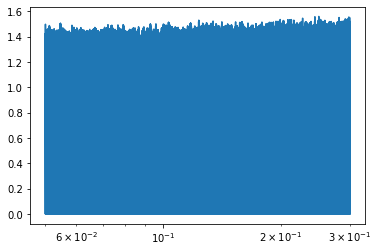

In [200]:
run.recorder.plot()

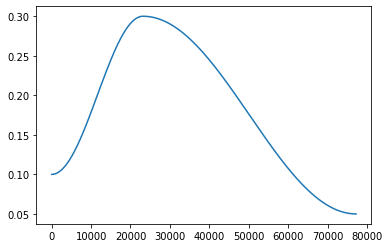

In [201]:
run.recorder.plot_lr()

- This should be same with following plot

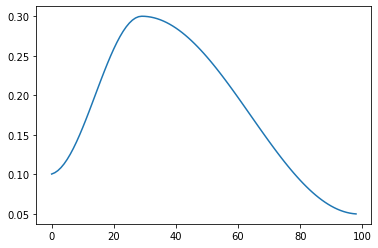

In [202]:
plt.plot([sched(o) for o in torch.arange(0., 1., 0.01)[1:]])

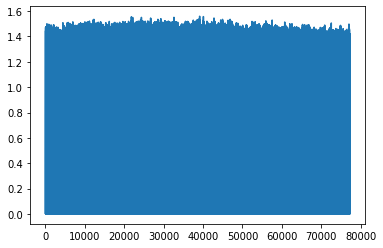

In [203]:
run.recorder.plot_loss()